In [146]:
import pandas as pd
import matplotlib.pyplot as plt
import scipy as sp


# Load the dataset
df_raw = pd.read_csv('ais_disabling_events.csv')

# Display the first few rows of the dataset
df_raw.head()

,gap_id,mmsi,vessel_class,flag,vessel_length_m,vessel_tonnage_gt,gap_start_timestamp,gap_start_lat,gap_start_lon,gap_start_distance_from_shore_m,gap_end_timestamp,gap_end_lat,gap_end_lon,gap_end_distance_from_shore_m,gap_hours
0,40072d9edfca0cfd28872cbf9e382e0c,111112726,other,NaN,32.064056,139.583282,2018-03-22 08:59:22+00:00,11.847433,-21.832185,384000.0,2018-03-22 22:00:56+00:00,11.412485,-23.689107,384000.0,13.016667
1,52dcbd77bbdad9ee2642f574acf45190,150402949,other,CHN,54.994278,904.204044,2019-01-31 04:09:19+00:00,-45.895618,-60.642950,396000.0,2019-01-31 18:00:44+00:00,-45.808745,-60.654917,392000.0,13.850000
2,22b6d49ed4bb4d017884b6299ed185f4,204201370,other,PRT,15.350000,40.940000,2018-05-27 04:47:20+00:00,37.836315,-29.405573,95000.0,2018-05-28 14:32:01+00:00,37.860093,-29.286443,87000.0,33.733333
3,1abe463d7f61b110c44f1d1b4654a213,204206740,other,PRT,20.000000,77.263333,2019-06-21 12:17:01+00:00,32.190453,-18.031552,98000.0,2019-06-22 18:56:01+00:00,32.119552,-18.123323,109000.0,30.650000
4,72d047a15e33f67c3c5b91c78ff612be,204209840,other,PRT,20.000000,87.435000,2017-07-02 13:13:08+00:00,39.388467,-29.215400,93000.0,2017-07-04 15:30:29+00:00,38.909333,-28.329817,17000.0,50.283333


In [147]:
df_sampled = df_raw.sample(n=30000, random_state=42)

#  calculate distance traveled between start and end of gap. 
from math import radians, cos, sin, asin, sqrt
def haversine(lon1, lat1, lon2, lat2):
    
    """
    Calculate the great circle distance in meters 
    between two points on the earth (specified in decimal degrees)
    """
    
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])

    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 

    # Radius of earth in kilometers is 6371
    nmi = 6371 * c * 0.53996 # convert to nautical miles
    return nmi

df_sampled['gap_dist_nmi'] = df_sampled.apply(lambda row: haversine(row['gap_start_lon'], row['gap_start_lat'], row['gap_end_lon'], row['gap_end_lat']), axis=1)


In [148]:
# count unique 'flag' in df_sampled
df_sampled['flag'].value_counts()

# find empty or blank values in flag column
df_sampled['flag'].isnull().sum()

399

### Calculate distance to home country

In [149]:
ais_data = df_sampled.copy()
ais_data = ais_data.iloc[:100, :]
ais_data

# Preprocess the data
# Drop rows where the 'flag' column is empty
ais_data = ais_data.dropna(subset=['flag'])

# Remove countries with 5 rows or less
country_counts = ais_data['flag'].value_counts()
countries_to_keep = country_counts[country_counts > 5].index
ais_data = ais_data[ais_data['flag'].isin(countries_to_keep)]
ais_data

,gap_id,mmsi,vessel_class,flag,vessel_length_m,vessel_tonnage_gt,gap_start_timestamp,gap_start_lat,gap_start_lon,gap_start_distance_from_shore_m,gap_end_timestamp,gap_end_lat,gap_end_lon,gap_end_distance_from_shore_m,gap_hours,gap_dist_nmi
20427,93f91a804ebd0df66d75effbe0d2fa6b,412329657,squid_jigger,CHN,70.870000,1655.000000,2019-11-24 03:34:35+00:00,41.887973,154.251947,555000.0,2019-11-25 09:16:41+00:00,41.360000,151.823333,487000.0,29.700000,113.511628
35460,3131c481da6368d0b0848815727c8105,416004728,tuna_purse_seines,TWN,70.590000,1288.000000,2019-02-16 07:48:00+00:00,-1.455093,151.148613,126000.0,2019-02-17 05:38:59+00:00,-1.553607,151.193620,119000.0,21.833333,6.502473
36795,7a486a9944cb3fd33bb048e4fe579e22,224253000,drifting_longlines,ESP,28.875000,217.090000,2019-07-12 07:32:00+00:00,42.041333,-46.535707,731000.0,2019-07-12 23:52:22+00:00,42.216347,-45.296107,791000.0,16.333333,56.188356
7182,ad16e866a778de1b25e6e0a73141d00b,412329693,trawlers,CHN,58.790000,1617.000000,2019-01-28 07:50:30+00:00,-45.622633,-60.552412,392000.0,2019-02-01 23:28:31+00:00,-46.109898,-60.718597,397000.0,111.633333,30.069484
12725,2a186f13a0c72c1cd2c2077bc43b4326,416505000,squid_jigger,TWN,69.735000,929.000000,2017-09-19 06:00:32+00:00,42.548682,152.617955,416000.0,2017-09-27 19:43:52+00:00,42.664412,153.422648,446000.0,205.716667,36.232744
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46331,646f11e0bd9d7c335122bf7d6babf3ef,416692000,drifting_longlines,TWN,47.876037,434.211452,2019-07-28 18:15:40+00:00,-7.386947,-2.204868,1015000.0,2019-07-29 14:11:48+00:00,-7.299432,-2.290547,1021000.0,19.933333,7.323929
14097,add28dfe8c5928d46120fec6f43a14a0,416253700,squid_jigger,TWN,74.550000,1238.000000,2019-07-19 03:45:38+00:00,45.503093,166.641600,911000.0,2019-07-19 16:29:54+00:00,46.444907,166.982040,808000.0,12.733333,58.304137
25862,d895bd8503e5f20bc069c17e88d05484,416242500,squid_jigger,TWN,74.550000,998.000000,2018-11-11 04:36:34+00:00,40.481770,150.598610,480000.0,2018-11-12 18:44:16+00:00,40.306667,152.093333,580000.0,38.116667,69.152622
15400,9daa0c14884ab4bed4823c49b777a2d5,416238600,squid_jigger,TWN,72.400000,960.000000,2019-08-03 09:07:49+00:00,41.251147,158.225840,801000.0,2019-08-05 20:06:30+00:00,41.193178,159.230253,858000.0,58.966667,45.492684


In [150]:
# load geo shape files from shape_files folder
import geopandas as gpd
from geopandas import GeoDataFrame
from shapely.geometry import Point, MultiPolygon
from geopy.distance import geodesic

# load shape files
countries_border_raw = gpd.read_file("shape_files_countries/ne_50m_admin_0_countries.shp")

# drop all columns except ADM0_A3 and geometry
countries_border = countries_border_raw[['ADM0_A3', 'geometry']]

# apply Douglas-Peucker simiplification algorithm to reduce the number of points
tolerance = 0.1 # adjustable
countries_border['geometry'] = countries_border['geometry'].simplify(tolerance, preserve_topology=True)

# left join ais_data with selected_countries
ais_border = ais_data.merge(countries_border, left_on='flag', right_on='ADM0_A3', how='left')

ais_border['gap_start_lat'].max(), ais_border['gap_start_lon'].max()

c:\Users\Geran\anaconda3\envs\ais_fishing_signal\Lib\site-packages\geopandas\geodataframe.py:1538: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


(48.9540833333, 177.729635)

In [155]:
def min_distance_to_geom(point, geom):
    """
    Calculate the minimum geodesic distance from a point to any vertex in a geometry (polygon/multipolygon).
    """
    if geom.geom_type == 'Polygon':
        coords = [(lat, lon) for (lon, lat) in geom.exterior.coords]
    elif geom.geom_type == 'MultiPolygon':
        coords = [(lat, lon) for poly in geom.geoms for (lon, lat) in poly.exterior.coords]
    else:
        coords = []
    
    # Use geopy's geodesic to calculate distances
    distances = [geodesic(point, coord).nm for coord in coords]

    # print(distances)
    
    return min(distances) if distances else float('inf')

In [156]:
# Apply the function to compute the minimum distance for each row
def compute_distance(row):
    # print(f"Processing row {row.name}")
    return min_distance_to_geom((row['gap_start_lat'], row['gap_start_lon']), row['geometry'])

ais_border['dist_from_home_nmi'] = ais_border.apply(compute_distance, axis=1)

ais_border

Processing row 0
[2071.5154006309344, 2075.2092087806254, 2075.8339448471606, 2072.7652962277057, 2071.5154006309344, 1670.15476975384, 1683.464383016925, 1689.2744403263657, 1679.6007744363858, 1670.15476975384, 1700.1977000039694, 1710.355597473882, 1708.4609427139146, 1697.2345488360788, 1700.1977000039694, 1715.0208762770903, 1718.7481444857362, 1716.6693186455707, 1713.8672883606048, 1715.0208762770903, 1697.8725288057085, 1700.7690996486945, 1699.5827079338435, 1696.050911235251, 1697.8725288057085, 1965.9458625039513, 1971.9645672342199, 1963.3311254570694, 1960.195538418047, 1965.9458625039513, 2534.6745601202883, 2529.1702554509484, 2534.3461942619565, 2542.6868962948715, 2534.6745601202883, 1809.4249374851684, 1815.4108840973263, 1812.7578763984045, 1807.263344685823, 1809.4249374851684, 2333.1254788737283, 2334.512735083477, 2335.898993682217, 2333.228452161935, 2333.1254788737283, 2411.759676347957, 2411.3929442998456, 2405.5719964335735, 2402.8710180081584, 2411.7596763479

### Output file as csv

In [159]:
output_file_path = "ais_disabling_events_30k_min_dist.csv"   
ais_border.to_csv(output_file_path, index=False)

### past drafts

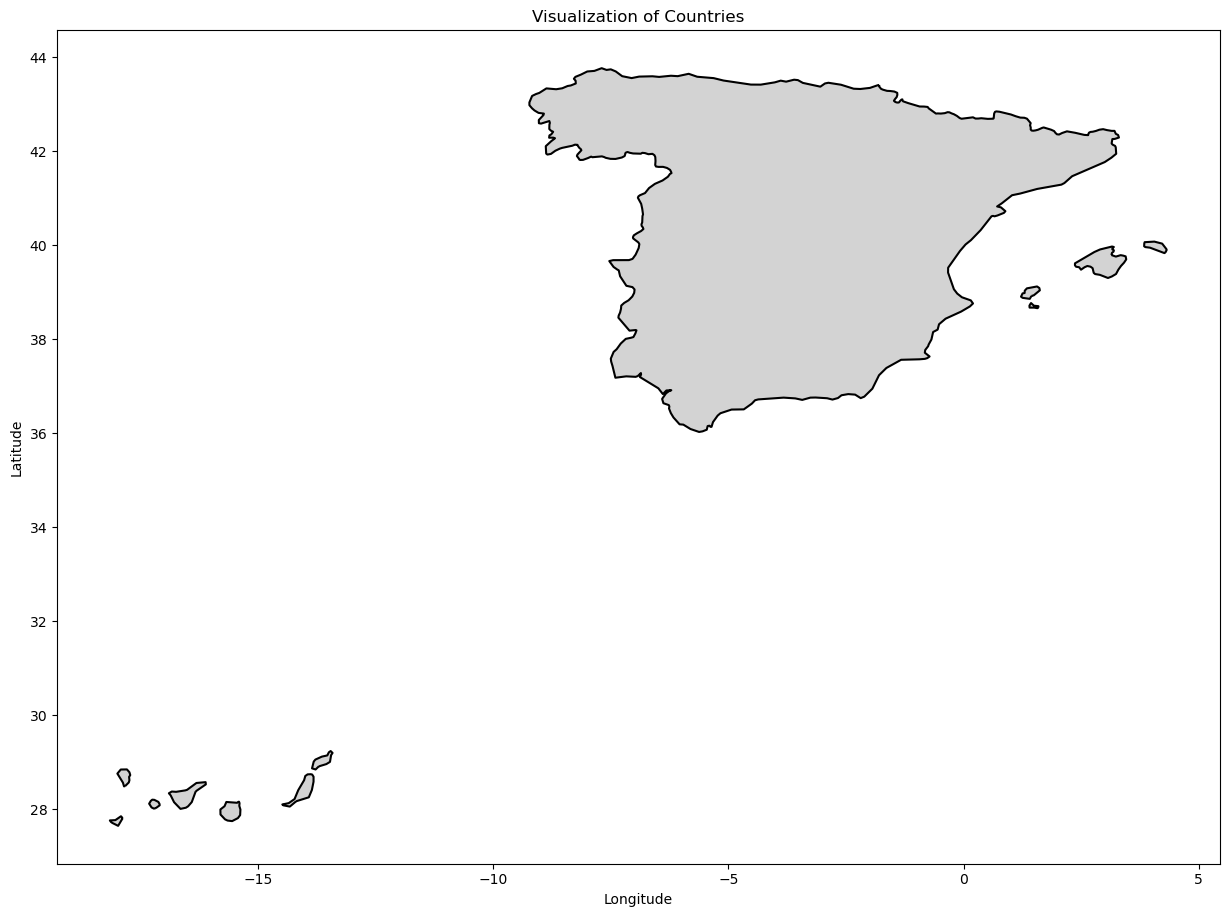

In [143]:
countries_border = countries_border_raw.copy()

# filter the country borders GeoDataFrame to only include the specified countries
selected_countries = countries_border[countries_border['ADM0_A3'].isin(['ESP'])]

# Plot the selected countries
fig, ax = plt.subplots(figsize=(15, 15))
selected_countries.plot(ax=ax, edgecolor='black', color='lightgray', linewidth=1.5)

# Set title and labels
ax.set_title("Visualization of Countries")
plt.xlabel("Longitude")
plt.ylabel("Latitude")

plt.show()


In [144]:
def num_points(geom):
    if geom.geom_type == 'Polygon':
        # Sum of exterior and all interior ring points
        return len(geom.exterior.coords) + sum(len(interior.coords) for interior in geom.interiors)
    elif geom.geom_type == 'MultiPolygon':
        # Recursively compute for each polygon and sum up
        return sum(num_points(polygon) for polygon in geom.geoms)
    else:
        return 0

selected_countries['num_points'] = selected_countries['geometry'].apply(num_points)
selected_countries[['SOVEREIGNT', 'num_points']]

c:\Users\Geran\anaconda3\envs\ais_fishing_signal\Lib\site-packages\geopandas\geodataframe.py:1538: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


,SOVEREIGNT,num_points
54,Spain,538


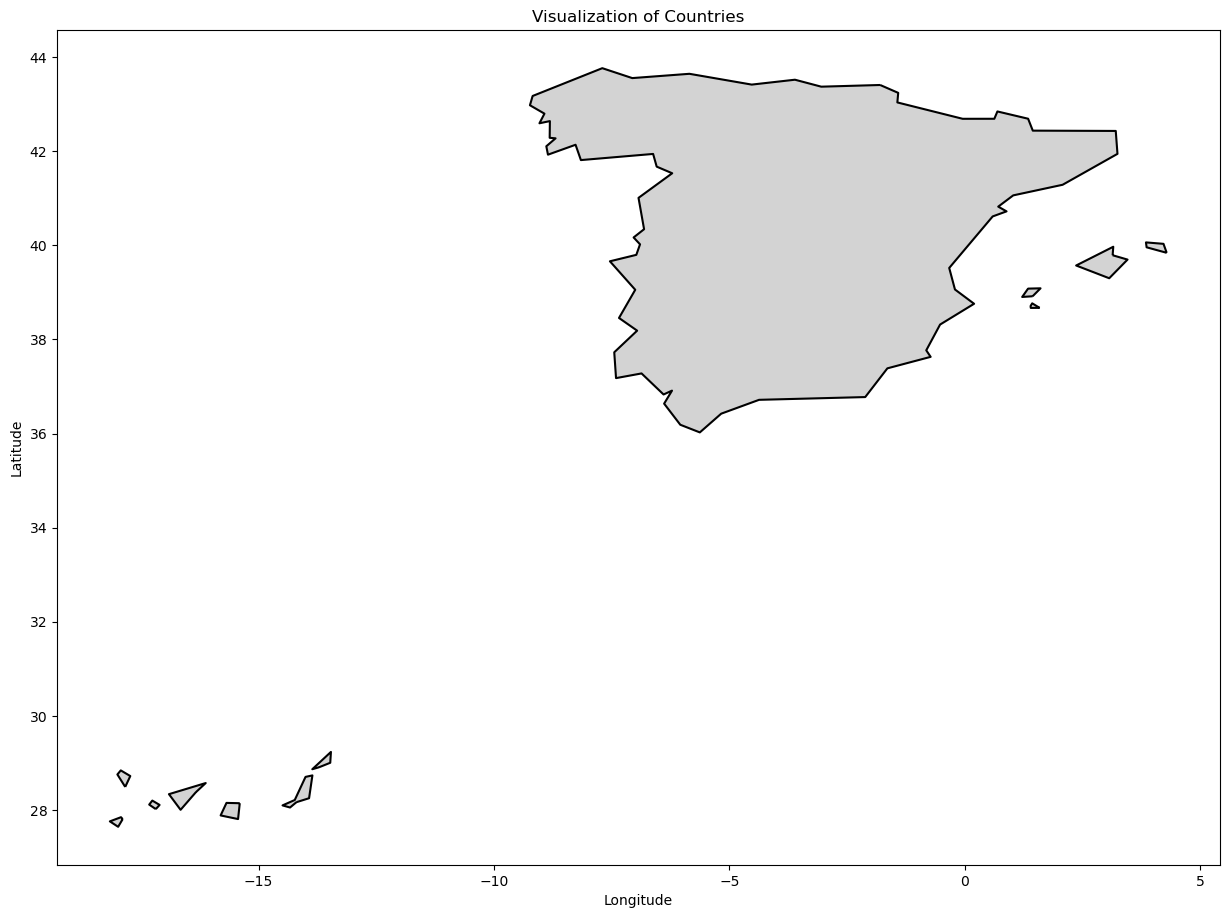

In [145]:
tolerance = 0.1
selected_countries_dpsimp = selected_countries.copy()
selected_countries_dpsimp['geometry'] = selected_countries_dpsimp['geometry'].simplify(tolerance, preserve_topology=True)

# Plot the selected countries
fig, ax = plt.subplots(figsize=(15, 15))
selected_countries_dpsimp.plot(ax=ax, edgecolor='black', color='lightgray', linewidth=1.5)

# Set title and labels
ax.set_title("Visualization of Countries")
plt.xlabel("Longitude")
plt.ylabel("Latitude")

plt.show()


In [142]:
selected_countries_dpsimp['num_points'] = selected_countries_dpsimp['geometry'].apply(num_points)
selected_countries_dpsimp[['SOVEREIGNT', 'num_points']]

,SOVEREIGNT,num_points
195,China,473


In [ ]:
# Convert the AIS dataframe to a GeoDataFrame
geometry = [Point(xy) for xy in zip(ais_data.gap_start_lon, ais_data.gap_start_lat)]
ais_geo = GeoDataFrame(ais_data, geometry=geometry)

ais_geo.head()
